# «Культурист-датасаентист»
Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. В рамках данного анализа был проведен исследовательский анализ данных(EDA) с целью выяснить какие параметры влияют на отток клиентов; была построена модель прогнозирования оттока клиентов и обучена двумя способами: методом логистической регрессии и случайным лесом; выполнена класеризация клиентов с целью выявления склонных к оттоку и надежных групп клиентов. Цель данной работы: провести анализ электронных анкет и подготовить план действий по удержанию клиентов сети.

#### Оглавление
1. [Загрузка данных](#start)
2. [Исследовательский анализ данных (EDA)](#2)
3. [Mодель прогнозирования оттока пользователей](#3)
4. [Кластеризация пользователей](#4)
5. [Общий вывод](#5)

#### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

### 1. Загрузка данных.  <a id='start'></a>

#### Путь к файлу данных

In [2]:
path='gym_churn.csv'

In [3]:
df=pd.read_csv(path, sep=',')
df.columns=df.columns.str.lower()
display(df.head(10))
print(df.info())
print(df.shape)
print("Таблица содержит {:.0f} дубликатов".format(df.duplicated().sum()))

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB
None
(4000, 14)
Таблица содержит 0

##### Вывод

Таблица с исходными данными имеет 4000 строк, не имеет пропусков и дубликатов. Набор данных включает следующие поля: 'Churn' — факт оттока в текущем месяце; 'gender' — пол, 'Near_Location' — проживание или работа в районе, где находится фитнес-центр, 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента), Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента), 'Phone' — наличие контактного телефона, 'Age' — возраст, 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах), 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год), 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах), 'Group_visits' — факт посещения групповых занятий, 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента, 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц, 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.    
Названия колонок были переведены в нижний регистр для удобства обращения к ним в ходе анализа.

### 2. Исследовательский анализ данных (EDA) <a id='2'></a>

In [4]:
print(df['gender'].value_counts())
print(df['near_location'].value_counts())
print(df['partner'].value_counts())
print(df['promo_friends'].value_counts())
print(df['phone'].value_counts())
print(df['contract_period'].value_counts())
print(df['group_visits'].value_counts())
print(df['age'].describe())
print(df['avg_additional_charges_total'].describe())
print(df['month_to_end_contract'].describe())
print(df['lifetime'].describe())
print(df['avg_class_frequency_total'].describe())
print(df['avg_class_frequency_current_month'].describe())
print(df['churn'].value_counts())

1    2041
0    1959
Name: gender, dtype: int64
1    3381
0     619
Name: near_location, dtype: int64
0    2053
1    1947
Name: partner, dtype: int64
0    2766
1    1234
Name: promo_friends, dtype: int64
1    3614
0     386
Name: phone, dtype: int64
1     2207
12     960
6      833
Name: contract_period, dtype: int64
0    2351
1    1649
Name: group_visits, dtype: int64
count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: age, dtype: float64
count    4000.000000
mean      146.943728
std        96.355602
min         0.148205
25%        68.868830
50%       136.220159
75%       210.949625
max       552.590740
Name: avg_additional_charges_total, dtype: float64
count    4000.000000
mean        4.322750
std         4.191297
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: month_to_end_contract, dtype: float64
coun

#### Вывод

Таблица с исходными данными имеет 4000 строк, не имеет пропусков и дубликатов. В исходных данных не было обнаружено вызывающих подозрение или выпадающих значений. В результате ознакомления с таблицей данных можно сделать вывод, что клиенты клуба - люди в возрасте от 18 лет до 41 года (средний возраст клиента - 29 лет), суммарная выручка от других услуг клуба колеблется от 0,14 до 552,60 и имеет среднее арифметическое значение равное 146,9, частота посещения зала в неделю колеблется от 0 до 6 раз и имеет средне арифметическое значение - около 2 (1,9).

#### Разделим данные на 2 группы по признаку оттока (churn)

In [5]:
df_churn_group=df.groupby(['churn']).mean()
pd.set_option('display.max_columns', None)
df_churn_group.columns=[x.replace('_',' ') for x in df_churn_group.columns]
df_churn_group.style.set_table_styles([dict(selector='th',props=[{'max-width','50px'}])])

,gender,near location,partner,promo friends,phone,contract period,group visits,age,avg additional charges total,month to end contract,lifetime,avg class frequency total,avg class frequency current month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.74719,0.464103,29.9765,158.446,5.28309,4.71181,2.02488,2.02788
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.72856,0.268615,26.9896,115.083,1.66258,0.990575,1.47499,1.04455


таблица демонстрирует, что те клиенты, кто остался (churn = 0) чаще являются сотрудниками компании-партнёра клуба, приходят в клуб по акции "приведи друга", имеют абонемент, в среднем, на 5,7 месяцев (те, кто оттошел от занятий имеют абонемент в среднем на 1,7 месяца), посещают групповые занятия, приносят больше суммарной выруки от других услуг фитнес-центра, и посещают занятия, в среднем, 2 раза в неделю. Остаются чаще люди более старшего возраста: средний возраст оставшихся - почти 30 лет, а средний возраст ушедших - почти 27 лет. Можно сделать вывод, что те, кто остаются клиентами клуба дольше месяца - становятся постоянными клиентами, т.к. среднее время с момента первого обращения в фитнес-центр для оставшихся клиентов составляет 4,7месяца, а для уходящих клиентов - чуть меньше 1 месяца.

##### столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

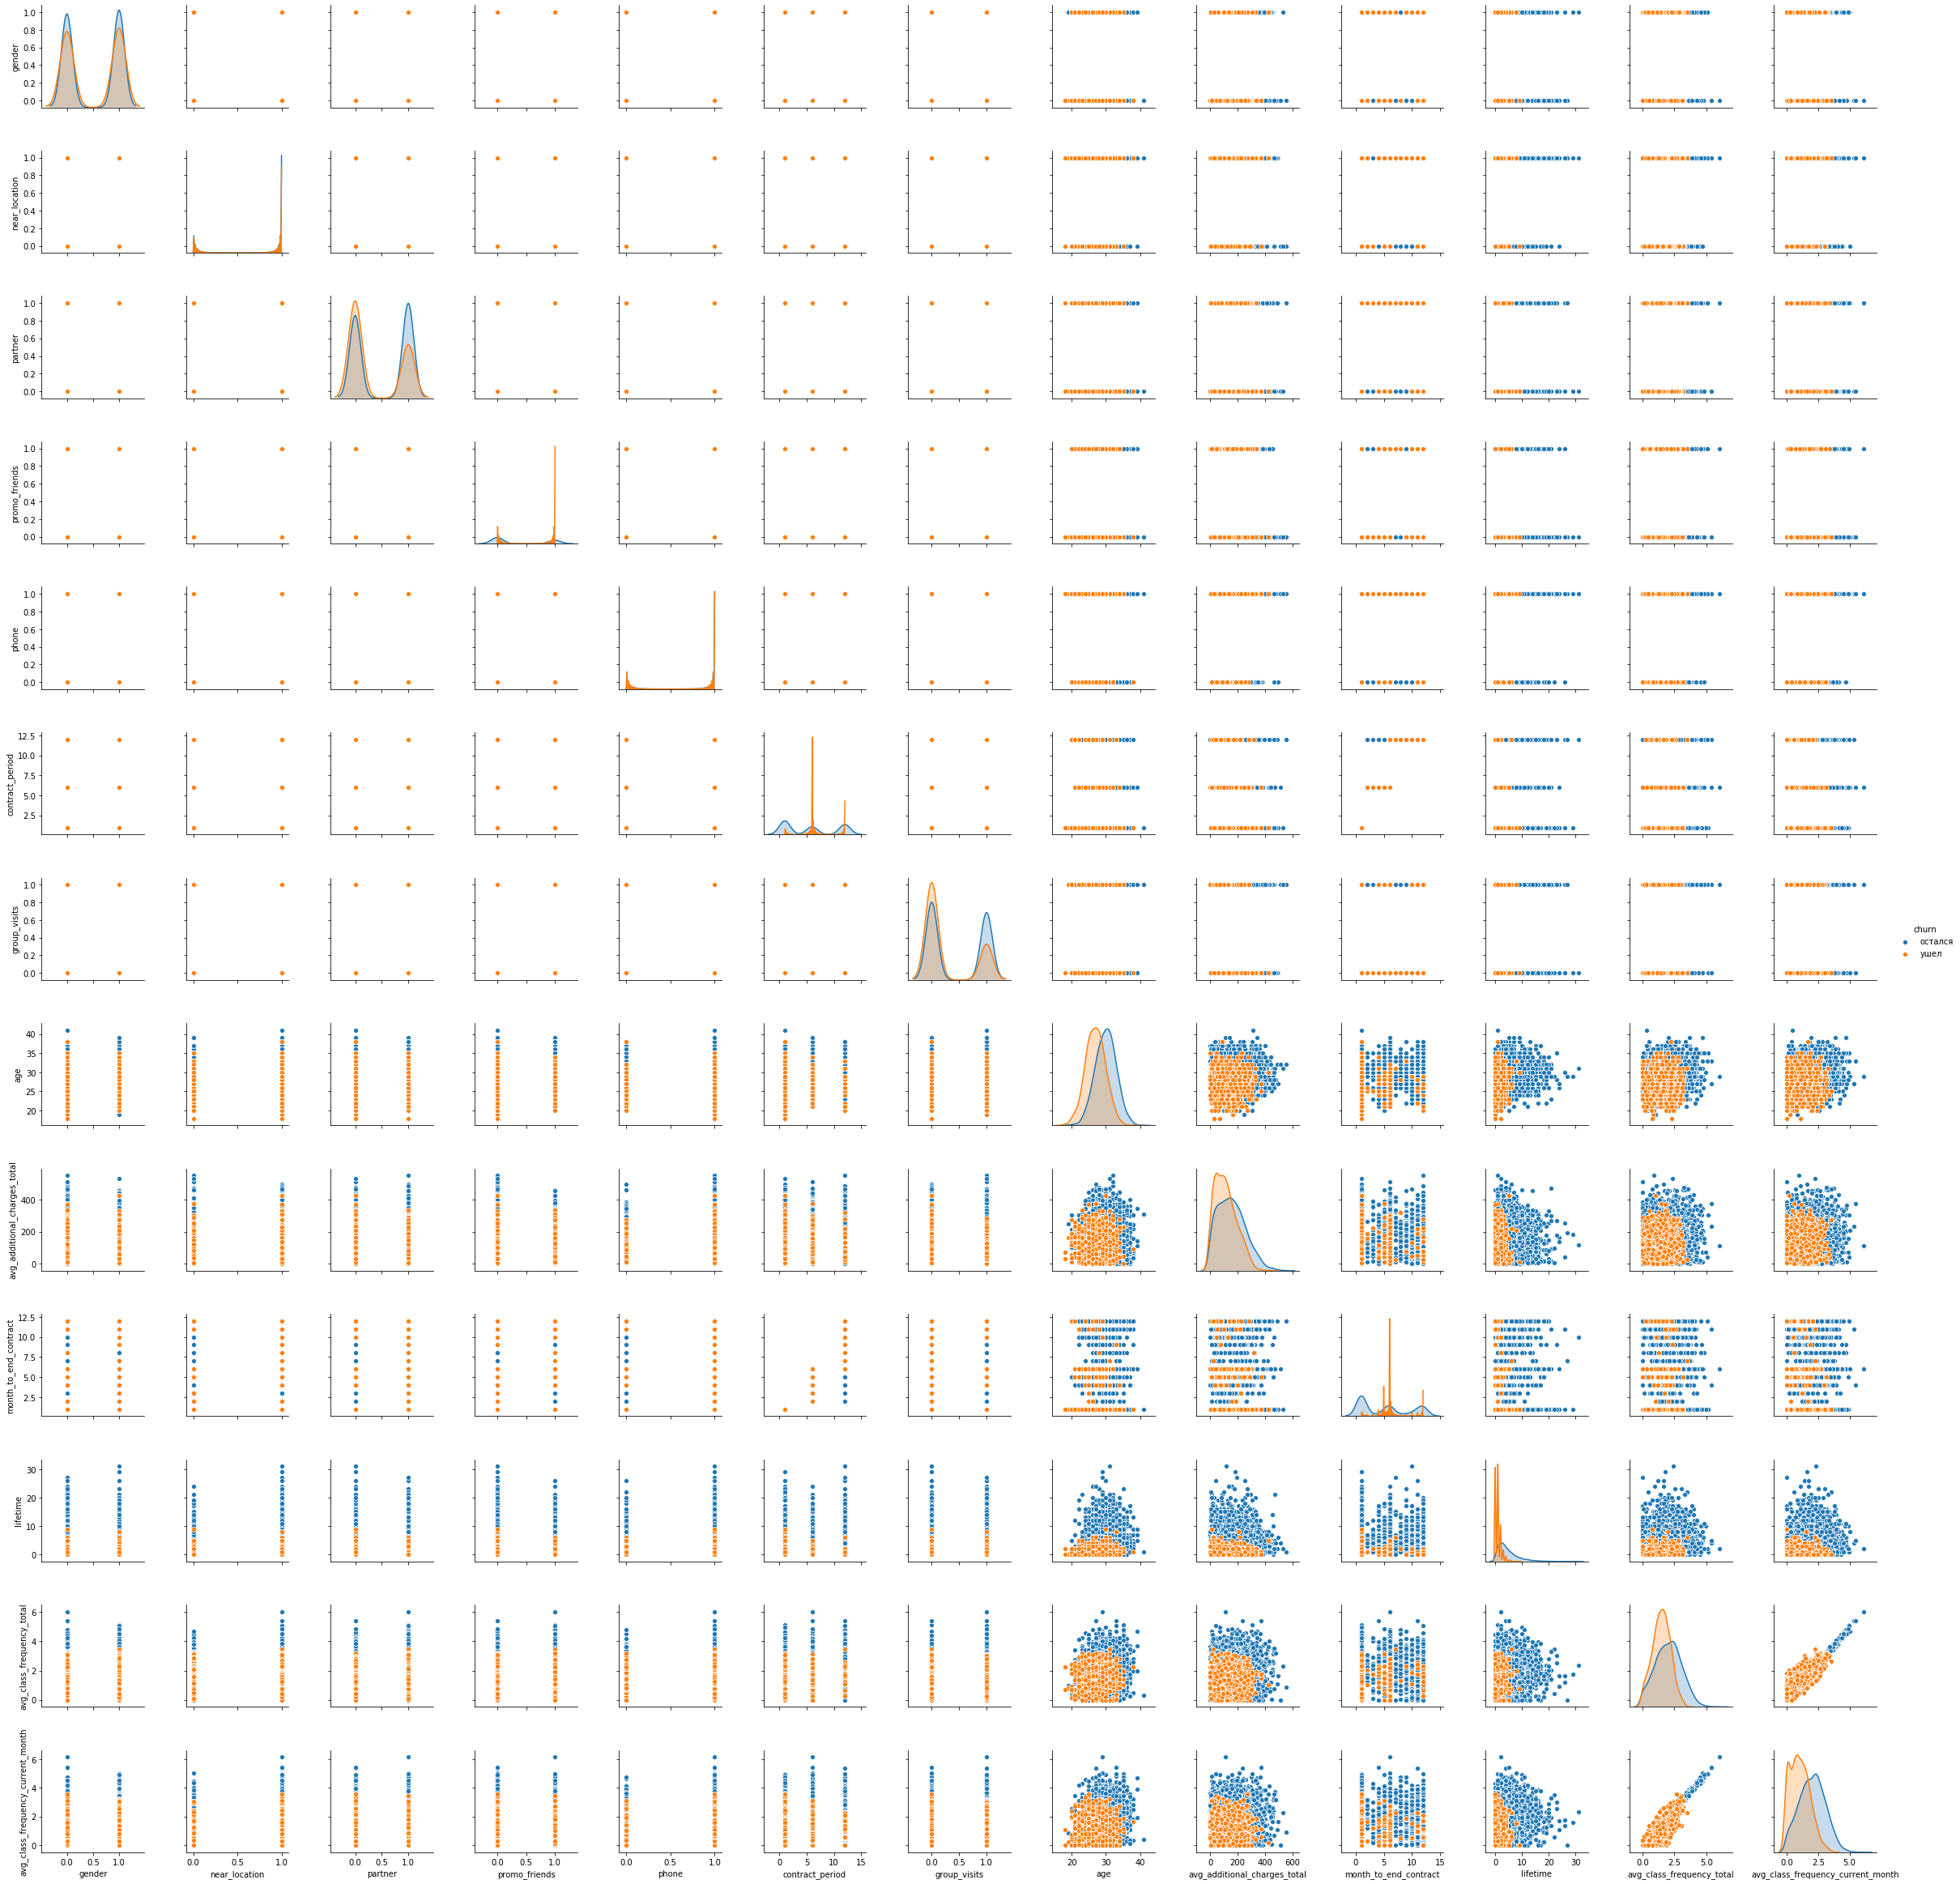

In [6]:
#список количественных переменных
list1=['age', 'lifetime', 'contract_period', 'avg_additional_charges_total', 'month_to_end_contract', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
#список категориальных пременных
list2=['gender','near_location', 'partner', 'promo_friends','phone', 'group_visits']
df1=df
df1=df1.replace({'churn':{0:'остался', 1:'ушел'}})
sns.pairplot(df1, hue='churn')
plt.show()

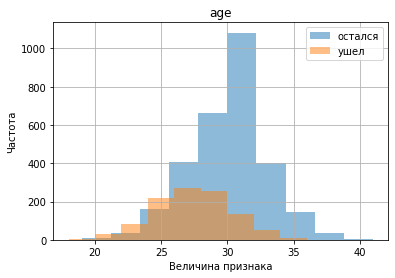

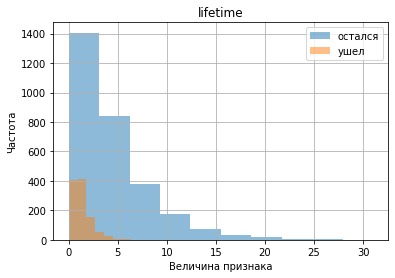

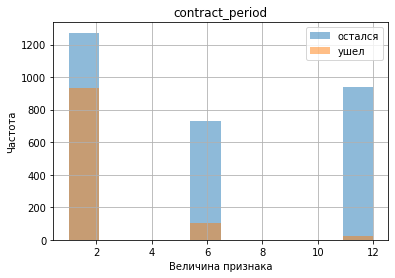

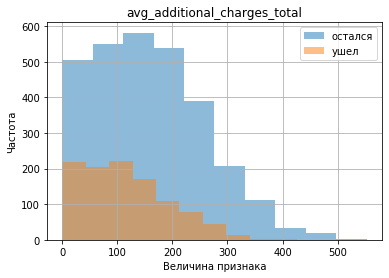

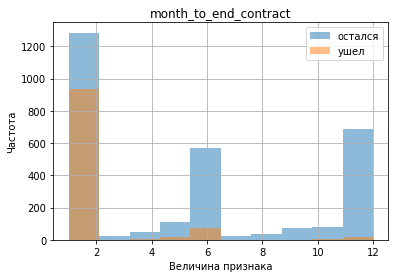

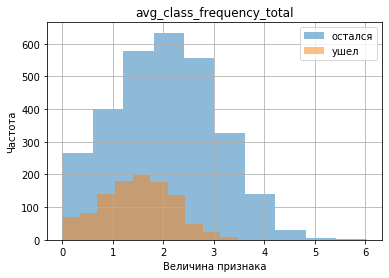

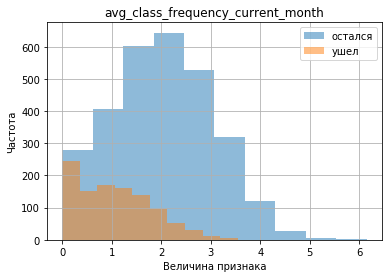

In [7]:
for i in list1:
    df1.groupby('churn')[i].hist(alpha=0.5)
    plt.legend(df1['churn'].unique())
    plt.xlabel("Величина признака")
    plt.ylabel("Частота")
    plt.title(i)
    plt.show()

##### Вывод

Гистограммы показывают, что чаще уходят молодые люди (от 20 до 26 лет), время с момента первого обращения которых в фитнес-центр составляет 1-2 месяца, с абонементом на 1 месяц. Суммарная выручка от других услуг фитнес-центра на долю ушедших относительно доли постоянных клиетов невелика.

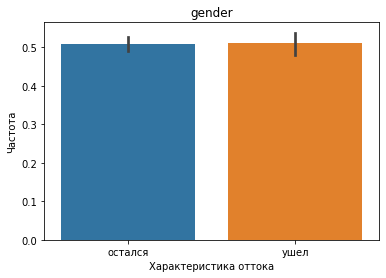

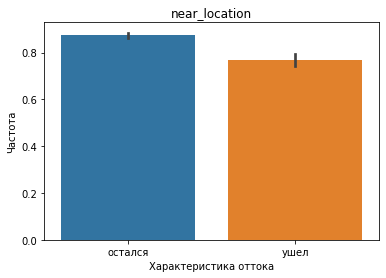

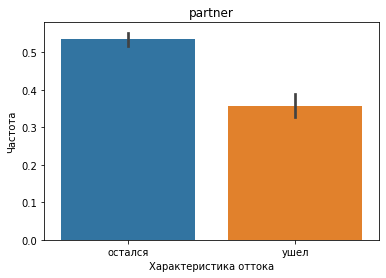

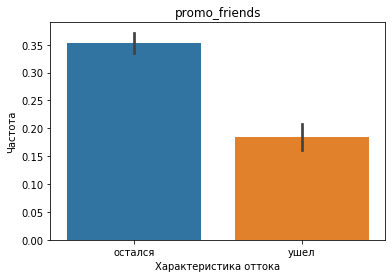

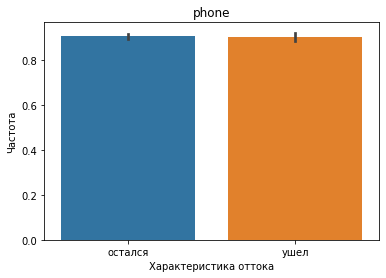

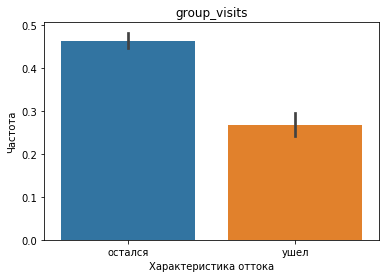

In [8]:
for i in list2:
    sns.barplot(data=df1, x='churn', y=i)
    plt.xlabel("Характеристика оттока")
    plt.ylabel("Частота")
    plt.title(i)
    plt.show()

##### Вывод

Графики показывают, что чаще остаются клиенты, которые живут или работают неподалеку, приходящие по акции "приведи друга" и посещающие групповые занятия. От пола клиента отток не зависит, другими словами, мужчины и женщины одинаково часто бросают занятия фитнесом в этой сети клубов.

#### матрица корреляций

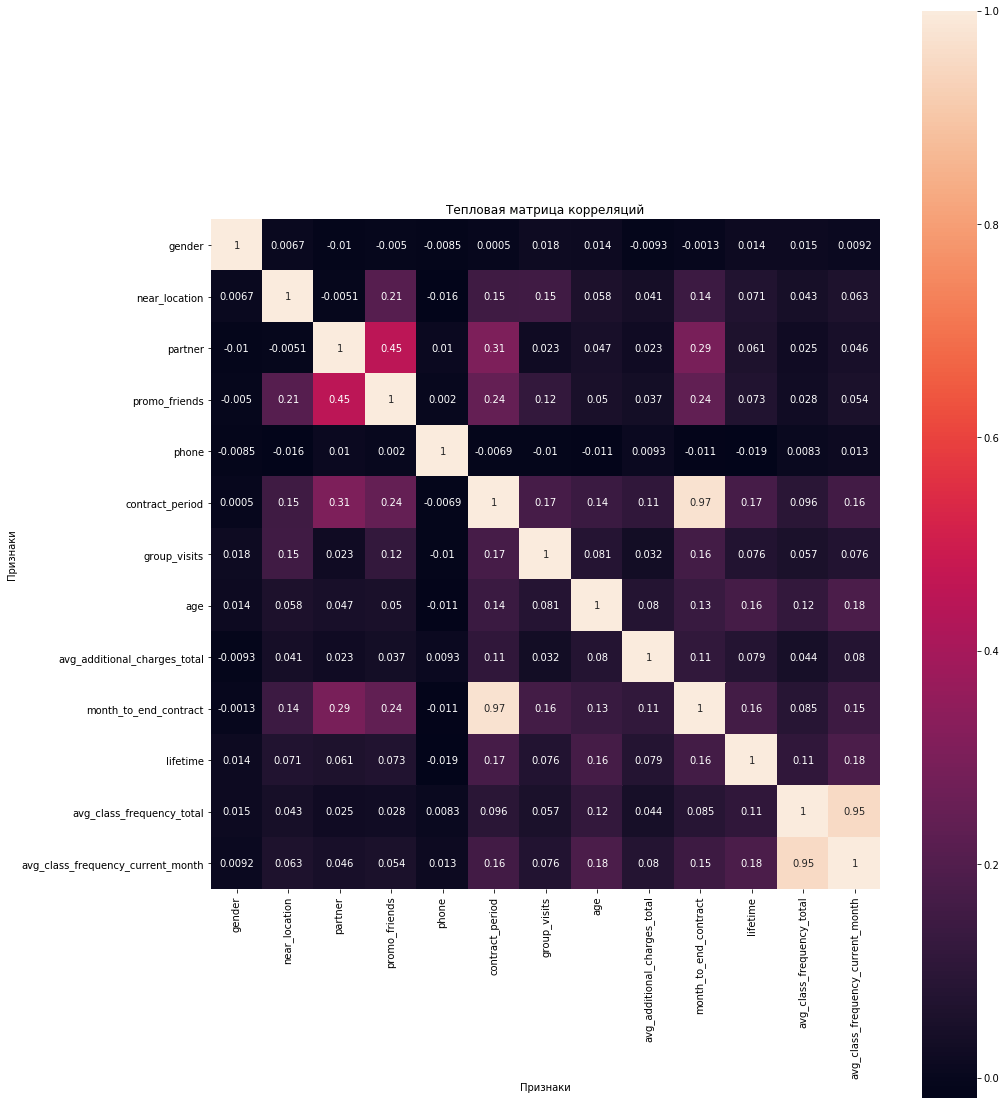

In [9]:
cm=df1.corr()
fig, ax = plt.subplots(figsize=(15, 20))
sns.heatmap(cm, annot=True, square=True)
plt.title('Тепловая матрица корреляций')
plt.xlabel("Признаки")
plt.ylabel("Признаки")
plt.show()

##### Вывод

Матрица корреляций показывает сильную связь между столбцами "средняя частота посещений в неделю за все время с начала действия абонемента" и "средняя частота посещений в неделю за предыдущий месяц", что говорит о стабильности посещений(или прогулов) тренировок клиентами. Так же можно видеть связь между признаками "сотрудник организации-партнера" и участник акции "приведи друга", что логично, т.к. зная о возможных привелегиях для сотрудников какой-либо организации будущие клиенты чаще пользуются акциями "приведи друга" и приходят познакомиться с клубом с коллегами, которые уже являются клиентами.

### 3. Модель прогнозирования оттока пользователей <a id='3'></a>

In [10]:
import warnings
warnings.filterwarnings('ignore')
#выделение данных
y = df['churn']
X = df.drop(['churn'], axis = 1)
#деление данных на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#стандартизация выборок
scaler=StandardScaler()
X_train_st=scaler.fit_transform(X_train)
X_test_st=scaler.transform(X_test)
#обучение моделей
model_lr = LogisticRegression(random_state=0)
model_rf=RandomForestClassifier(n_estimators=100, random_state=0)
model_lr.fit(X_train_st,y_train)
model_rf.fit(X_train_st,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [11]:
#модель логистической регрессии
y_pred=model_lr.predict(X_test_st)
accuracy=accuracy_score(y_test, y_pred)
precision=precision_score(y_test,y_pred)
recall=recall_score(y_test, y_pred)
print("Доля правильных ответов",accuracy)
print("Точность", precision)
print("Полнота", recall)

Доля правильных ответов 0.9225
Точность 0.8541666666666666
Полнота 0.8282828282828283


In [12]:
#модель случайного леса
y_pred2=model_rf.predict(X_test_st)
accuracy2=accuracy_score(y_test, y_pred2)
precision2=precision_score(y_test,y_pred2)
recall2=recall_score(y_test, y_pred2)
print("Доля правильных ответов",accuracy2)
print("Точность", precision2)
print("Полнота", recall2)

Доля правильных ответов 0.915
Точность 0.8385416666666666
Полнота 0.8131313131313131


##### Вывод

В результате сравнения двух моделей можно видеть, что доля правильных ответов(accuracy), точность(precision) и полнота(recall) выше в случае применения модели логистической регрессии. исходя и этого можно сделать вывод, что в данном случае модель логистической регрессии оказалась точнее.

### 4. Кластеризация пользователей <a id='4'></a>

In [13]:
df3=df
#стандартизация данных
scaler=StandardScaler()
x_sc=scaler.fit_transform(df3)


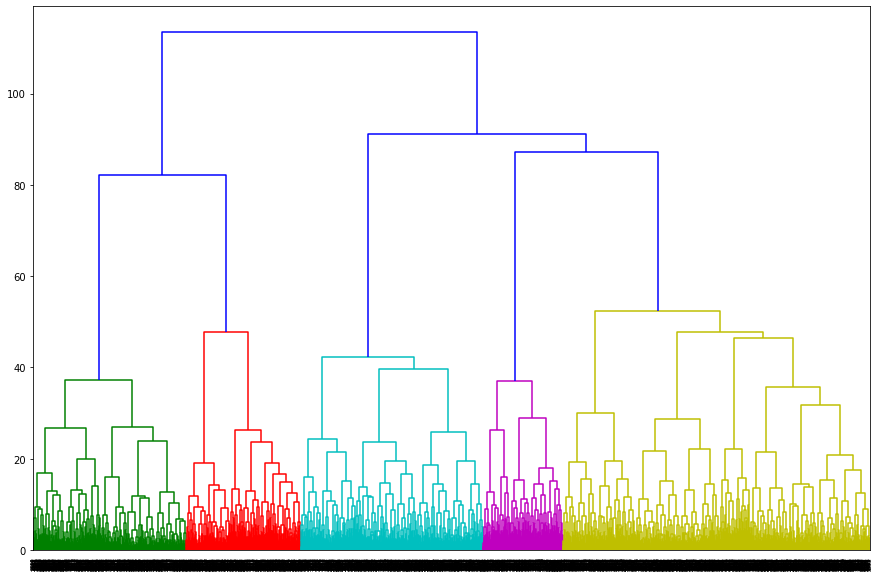

In [14]:
#построение матрицы расстояний и дендрограммы
linked=linkage(x_sc, method='ward')
plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.show()

Из дендрограммы можно сделать вывод, что оптимальное количество кластеров - 5, т.к. на графике 5 цветов.

In [15]:
#задаем модель k_means с числом кластеров 5
km=KMeans(n_clusters=5)
#прогнозируем кластеры для наблюдений
labels=km.fit_predict(x_sc)
#сохраняем метки кластера в поле датасета
df3['cluster']=labels
#вывод статистики по средним значениям признаков по кластеру
df3.groupby(['cluster']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.506908,0.759830,0.341126,0.179596,0.996812,1.566419,0.257173,26.907545,114.993470,1.513284,0.975558,1.448150,1.025562,0.997875
1,0.503650,0.938478,0.767466,0.563087,1.000000,11.199166,0.558916,29.880083,162.792871,10.254432,4.683003,2.031016,2.025194,0.015641
2,0.546929,0.844728,0.367323,0.209733,0.998841,2.676709,0.436848,29.988413,160.879827,2.469293,4.600232,2.904467,2.912142,0.006952
3,0.477193,0.824561,0.459649,0.264327,1.000000,2.761404,0.385965,30.028070,151.348090,2.552047,4.688889,1.157304,1.155556,0.001170
4,0.526178,0.869110,0.471204,0.308901,0.000000,4.816754,0.429319,29.340314,144.517762,4.502618,3.955497,1.857525,1.727260,0.261780


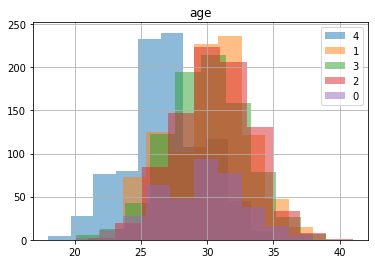

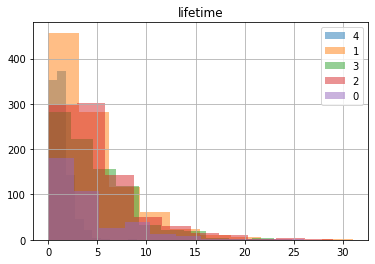

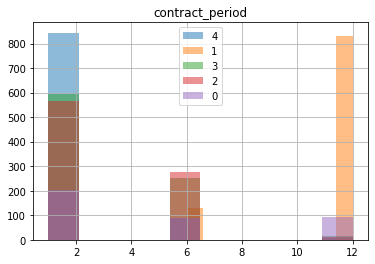

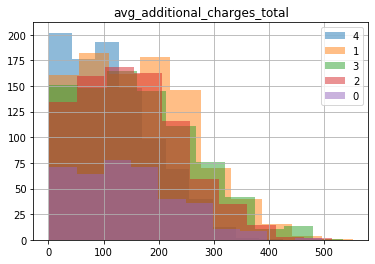

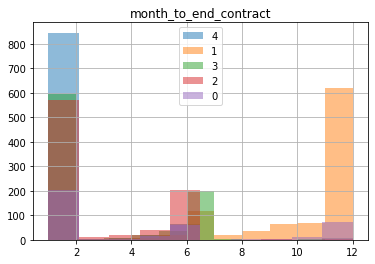

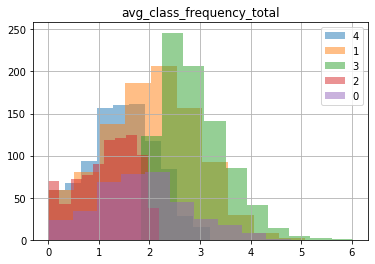

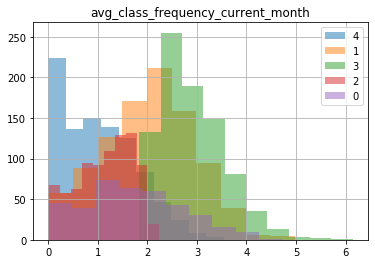

In [16]:
for i in list1:
    df3.groupby('cluster')[i].hist(alpha=0.5)
    plt.legend(df3['cluster'].unique())
    plt.title(i)
    plt.show()

##### Вывод

Исходя из полученных гистограмм можно сформулировать характеристики кластеров: в кластер 4 входят люди от 18 до 28 лет, в кластер 0 и кластер 3- от 28 до 33 лет, в кластер 1 - от 27 до 32 лет, в кластер 2 - от 27 до 34 лет. Люди, остосящиеся к кластеру 0 чаще оформляли абонементы на 12 месяцев, а к кластеру 4 - на 1 месяц, к кластеру 3 - на 6 месяцев. Среднее количество посещений занятий за всё время действия и абонементов для людей, относящихся к кластеру 0 - 1-3 раза в неделю, к кластеру 1 - 2-3 раза в неделю к кластеру 2 - посещают занятия в среднем 2-4 раза в неделю, к кластеру 3 - до 2 раз в неделю, а к кластеру 4 - 1-2 раза в неделю. Среднее количество посещений занятий за последний месяц для людей, относящихся к кластеру 0 - 1-3 раза в неделю, к кластеру 1 - 1-2 раза в неделю, к кластеру 2 - более 2 раз в неделю, к кластеру 3 - до 2 раз в неделю, к кластеру 4 - 1 раз в неделю и меньше.

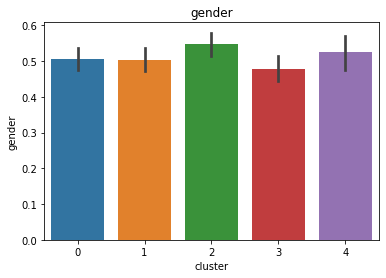

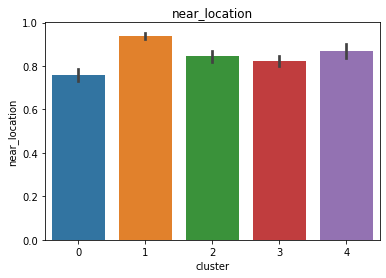

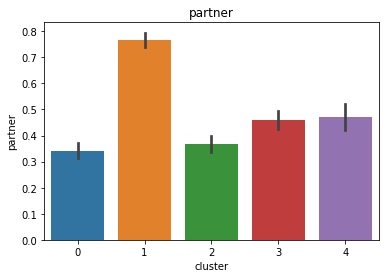

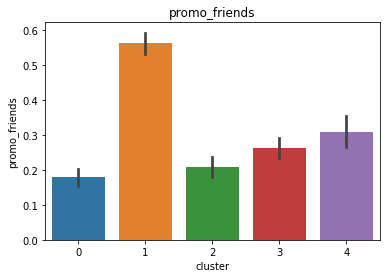

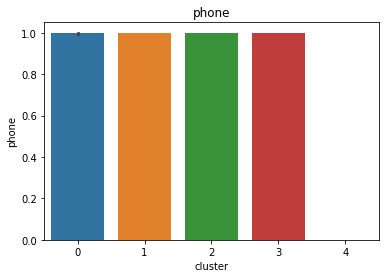

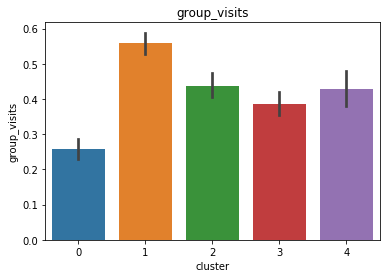

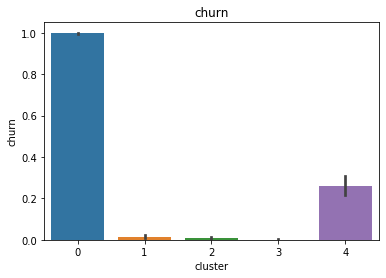

In [17]:
list3=list2+['churn']
for i in list3:
    sns.barplot(data=df3, x='cluster', y=i)
    plt.title(i)
    plt.show()

##### Вывод

Т.к. женщины в исходной таблице обозначены 1, а мужчины 0 (исходя из открытой статистики посещения фитнес-клубов, женщины намного чаще являются клиентами фитнес-клубов), то в кластере 0 больше женщин, а в кластере 1 - меньше женщин. Графики говорят, что наиболее близко к клубу живут(или работают) люди, принадлежащие к кластеру 3, а дальше - к кластеру 4; люди, принадлежащие к кластеру 3 чаще пользуются акцией "приведи друга" и являются сотрудниками компаний-партнеров клуба, а к кластеру 4- реже остальных приходят по акции или работают в компании-партнере. Люди принадлежащие к кластерам 0, 1, 3 и 4 оставляли свои номера телефонов, а принадлежащие к кластеру 2 -нет. На групповые тренировки чаще ходят люди, принадлежащие к кластеру 3, реже всех остальных- к кластеру 4. Чаще покидают клуб люди, принадлежащие к кластреам 4 и 2. 

### 5. Общий вывод   <a id='5'></a>

В результате проведенного анадиза были сделаны следующие выводы:
**1.** Клиенты клуба - люди в возрасте от 18 лет до 41 года (средний возраст клиента - 29 лет).  
**2.** Те клиенты, кто остался чаще являются сотрудниками компании-партнёра клуба, приходят в клуб по акции "приведи друга", имеют абонемент, в среднем, на 5,7 месяцев (те, кто отошел от занятий имеют абонемент в среднем на 1,7 месяца), посещают групповые занятия, приносят больше суммарной выруки от других услуг фитнес-центра, и посещают занятия, в среднем, 2 раза в неделю. Матрица корреляций показывает сильную связь между столбцами "средняя частота посещений в неделю за все время с начала действия абонемента" и "средняя частота посещений в неделю за предыдущий месяц", что говорит о стабильности посещений(или прогулов) тренировок клиентами. Так же можно видеть связь между признаками "сотрудник организации-партнера" и участник акции "приведи друга".     
**3.** Чаще уходят молодые люди (от 20 до 26 лет), время с момента первого обращения которых в фитнес-центр составляет 1-2 месяца, с абонементом на 1 месяц.   
**4.** Чаще остаются клиенты, которые живут или работают неподалеку, приходящие по акции "приведи друга" и посещающие групповые занятия.    
**5.** От пола клиента отток не зависит.      
Была построена модель прогнозирования оттока клиентов. Модель была обучена 2 методами: логистической регрессией и случайным лесом. В результате сравнения двух моделей было найдено, что в данном случае модель логистической регрессии оказалась точнее.   
Была сделана кластеризация клиентов. В результате анализа было выделено 5 характерных групп клиентов:      
**1.** В этой группе преимущественно женщины, от 28 до 33 лет, имеющие абонементы на 12 месяцев. Среднее количество посещений занятий за всё время действия и абонементов 1-3 раза в неделю.   
**2.** В этой группе больше мужчин, от 27 до 32 лет. Среднее количество посещений занятий за всё время действия и абонементов 2-3 раза в неделю.   
**3.** В этой группе люди от 27 до 34 лет. Среднее количество посещений занятий за всё время действия и абонементов 2-4 раза в неделю. Люди из этой группы не оставляли номера телефонов. Люди, принадлежащие к этой группе часто покидают клуб.   
**4.** В эой группе от 28 до 33 лет, имеющие абонементы на 6 месяцев. Среднее количество посещений занятий за всё время действия и абонементов до 2 раз в неделю. Они наиболее близко живут или работают к клубу, чаще пользуются акцией "приведи друга" и являются сотрудниками компаний-партнеров клуба, групповые тренировки посещают чаще.    
**5.** В эту группу входят люди от 18 до 28 лет, имеющие абонементы на 1 месяц. Среднее количество посещений занятий за всё время действия и абонементов 1-2 раза в неделю. Они наиболее далеко живут или работают от клуба, реже остальных приходят по акции или работают в компании-партнере, реже остальных посещают групповые тренировки. Люди, принадлежащие к этой группе наиболее часто покидают клуб.     

#### Рекомендации

В результате проведенного анализа была выявлена закономерность между фактом работы в компании-партнере и участием в акции "приведи друга". На основании этого можно сформулировать рекомендацию: заключать больше соглашений с близлежащими организациями на скидки для их сотрудников. Клиентам будет удобнее посещать клуб из-за близости к месту работы и они будут рекомендовать клуб и занятия фитнесом своим коллегам.    
Чаще становятся постоянными клиентами люди, имеющие абонементы на 6 месяцев и более. Если разместить рекламу акции на длительный абонемент в ближайщих продуктовых магазинах, то это может помочь привлечь людей, живущих неподалеку от клуба.    
Люди, посещающие групповые тренировки чаще становятся постоянными клиентами, можно предположить, что разнообразие групповых тренировок может привлечь больше клиентов. Можно провести опрос среди клиентов клуба какие тренировки и в какое удобное время  они хотели бы посещать и, возможно, ввести новые направления групповых тренировок.